NOMBRE:

APELLIDOS:

# Discretización temporal no uniforme: DOPRI5

<ul id="top">
<li><a href="#Definiciones">Definiciones</a></li>
<li><a href="#Problemas:-órbitas-de-gran-excentricidad">Problemas: órbitas de gran excentricidad</a></li> 
<ul>
       <li><a href="#Problema-test:-dos-cuerpos-en-el-plano">Problema-test: dos cuerpos en el plano</a></li> 
       <li><a href="#Problema-del-satélite-artificial">Problema del satélite artificial</a></li>
</ul>
<li><a href="#Métodos RK5 y DOPRI5">Métodos RK5 y DOPRI5</a></li>
      <ul>
        <li><a href="#Implementación-del-método-RK5">Implementación del método RK5</a></li>
        <li><a href="#Implementación-del-método-DOPRI5">Implementación del método DOPRI5</a></li>
</ul>  

    
<li><a href="#Comparativa-de-eficiencia-(error-en-energía)">Comparativa de eficiencia (error en energía)</a></li>


<li><a href="#Comparativa-de-eficiencia-(error-en-posiciones)">Comparativa de eficiencia (error en posiciones)</a></li>
    

</ul>  

## Definiciones

In [1]:
using LinearAlgebra
using Plots

In [2]:
struct ProblemaEDOs{ttype,utype,ptype,ftype}
    f::ftype
    u0::utype
    tspan::Tuple{ttype,ttype}
    p::ptype
end

struct SolucionProblemaEDOs{ttype,utype,ptype,ftype}
    t::Vector{ttype}
    u::Vector{utype}
    prob::ProblemaEDOs{ttype,utype,ptype,ftype}
end


# Problemas: órbitas de gran excentricidad

### Ejercicio 1

## Problema-test: dos cuerpos en el plano 

El problema de dos cuerpos en el plano describe muy bien los principales aspectos del movimiento de los satélites.
Para calcular el movimiento de dos cuerpos que se atraen mutuamente, elegimos uno de los cuerpos como el centro de nuestro sistema de coordenadas; el movimiento del segundo cuerpo se realiza en el plano y su posición viene dada por las coordenadas $q=(q_1,q_2)$. La ley de Newton, con una normalización adecuada, da como resultado la siguiente ecuación diferencial,
 

\begin{align*}
& \frac{d}{dt} q_x= v_x, \quad  \frac{d}{dt} q_y= v_y \\
&\frac{d}{dt} v_x= - \frac{q_x}{r^3}, \quad \frac{d}{dt} v_y= - \frac{q_y}{r^3} \\
& \text{donde} \quad r=\sqrt{q_x^2+q_y^2}
\end{align*}

Los valores iniciales para $t = 0$ que describen una órbita con semieje mayor $a = 1$ y excentricidad $e$ que comienza en el pericentro están dados por

\begin{align*}
q_x(0)=1-e, \quad q_y(0)=0, \quad v_x(0)=0, \quad v_y(0)=\sqrt{(1+e)/(1-e)}
\end{align*}


Consideraremos el siguiente **problema de valor inicial** para el modelo de dos cuerpos en el plano:  
 
 - Estado inicial que corresponde al valor de la excentricidad $e=0.76$
 - Intervalo de integración $(t_0,t_f)=(0.,2\pi)$

- **Implementar la función que define la EDO del problema de dos cuerpos en el plano**

In [3]:
function f_2body!(du,t,u,p)

  qx=u[1]
  qy=u[2]
  vx=u[3]
  vy=u[4]  

  r2=qx*qx+qy*qy
  r=sqrt(r2)
  aux=1/(r2*r)
  
  du[1]=vx 
  du[2]=vy
  du[3]=-qx*aux
  du[4]=-qy*aux    
    
  return nothing
    
end


e = 0.76            
t0 = 0.
tf = 2*pi     
p=Float64[]

tspan=(t0,tf)
u0_2b=[1.0-e ,0.0, 0.0,sqrt((1+e)/(1-e))]
prob_test=ProblemaEDOs(f_2body!,u0_2b,tspan,p);

## Problema del satélite artificial

Consideraremos la evolución de un satélite artificial moviéndose bajo el influjo gravitacional de la tierra. 

 En el modelo matemático que consideramos a continuación, se tiene en cuenta el ligero achatamiento que presenta la tierra en los polos. (Sin embargo, no se tiene en cuenta otros efectos de índole menor, como  el efecto gravitacional de la luna, el sol, y otros cuerpos celestes, ni el efecto de irregularidades menores del campo gravitacional de la tierra).
Las unidades utilizadas son kilómetros para la distancia, y segundos para el tiempo.

Según este modelo matemático, las coordenadas respecto del centro de la tierra $(x,y,z)$ del satélite obedecen el siguiente sistema de ecuaciones diferenciales:

\begin{align*}
\frac{d}{dt} 
\left(
  \begin{matrix}
    x \\ y \\ z \\v_x \\ v_y\\ v_z
  \end{matrix}
\right)
&=
\left(
  \begin{matrix}
 v_x\\
 v_y\\
 v_z\\
 \displaystyle -\mu \frac{x}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, F \right)\\ 
 \displaystyle -\mu \frac{y}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, F \right)\\ 
\displaystyle-\mu \frac{z}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, G \right)
  \end{matrix}
\right).
    \end{align*}

donde 
\begin{equation*}
r=\sqrt{x^2+y^2+z^2}, \quad
  F = \frac{3}{2} -  \frac{15z^2}{2r^2},  \quad G = \frac{9}{2} - \frac{15z^2}{2r^2},
\end{equation*}

y $\mu$, $R$, y $\epsilon$, respectivamente, son la constante gravitacional, el radio, y el coeficiente de achatamiento del planeta alrededor del cual se mueve el satélite artificial. En el caso de la tierra, tenemos que

\begin{equation*} 
    \mu = 398600.8 Km^3/s^2, \quad R = 6\, 378.135Km,  \quad               
    \epsilon = 0.0010826157.
\end{equation*}

    
Este es un sistema conservativo, en el que la energía del sistema se mantiene constante a lo largo de cada solución. Dicha energía es

\begin{equation*}
E(u,\mu) = \frac12\, (v_x^2 + v_y^2+ v_z^2) - \frac{\mu}{r}
-\frac{\mu  R^2 \epsilon }{2\, 
   r^3}+\frac{3 \mu  R^2 z^2 \epsilon }{2\, r^5},
\end{equation*}

donde $u$ es el vector de estados $u=(x,y,z,v_x,v_y,v_z)$. (En realidad $E(u,\mu)$ es la energía del satélite divida por su masa, pero nos referiremos a $E(u,\mu)$ como la energía del sistema.)

Aparte de la energía, también se conserva la componente vertical del momento angular, es decir,  $x v_y - y v_x.$

- **Implementar la función que define la EDO del satétile y la función del cálculo de la energía del sistema**

In [4]:
function fsat2!(du,t,u,p)
    
    μ = p[1]
    R = p[2]
    ϵ = p[3]
    x = u[1]
    y = u[2]
    z = u[3]
    du[1] = u[4]
    du[2] = u[5]
    du[3] = u[6]
    r2 = x^2+y^2+z^2
    r = sqrt(r2)
    aux1 = -μ/(r*r2)
    F = 1.5 - 7.5*(z/r)^2
    G =  3 + F
    aux2 = ϵ*(R/r)^2
    aux3 = aux1*(1+aux2*F)
    aux4 = aux1*(1+aux2*G)
    du[4]=aux3*x
    du[5]=aux3*y
    du[6]=aux4*z
    return nothing
end

"""
Energia
"""
function Efun(u,p) 

    μ = p[1]
    R = p[2]
    ϵ = p[3]
    z = u[3]
    v2 = u[4]^2 + u[5]^2 + u[6]^2
    r = norm(u[1:3])
    return  0.5*v2 - μ/r * (1 + 0.5*ϵ*(R/r)^2 * (1 - 3*(z/r)^2))   
end

μ = 398600.8
R = 6378.135
ϵ = 0.0010826157
T =47120.401733054;

### Condiciones iniciales

A lo largo del presente documento, consideraremos las siguientes condiciones iniciales:

\begin{equation*}
  \begin{split}
 x(0)&=1.1959886901183693e4 \, Km,\  \qquad y(0)=-1.6289448826603336e4 \, Km,\  \qquad z(0)=-5.963757695165331e3\, Km, \\ 
 v_x(0)&=4.724300951633136 \, Km/s, \quad v_y(0)=-1.1099935305609756 \, Km/s, \quad v_z(0)=-0.3847854410416176\,  Km/s
  \end{split}
\end{equation*}

corresponden a **un satélite de gran excentricidad** ($e=0.7679436$), es decir, que permanece gran parte de su tiempo en las proximidades del apogeo y pasa muy rápido por el resto de regiones. 

In [5]:
q0=[1.1959886901183693e4,-1.6289448826603336e4,-5.963757695165331e3] # Km   
v0=[4.724300951633136,-1.1099935305609756,-0.3847854410416176]        #km/s  
u0_sat=vcat(q0,v0); 

### Prob_sat


Si la tierra fuera una esfera con campo gravitacional uniforme, dichas condiciones iniciales darían lugar a una  órbita periódica de periodo $T=47120.401733054\, s$ .  Pero dado que en el modelo matemático considerado se tiene en cuenta el ligero achatamiento de la tierra en los polos, **la órbita del satélite es solo aproximadamente periódica**. Creamos una problema de valor inicial para el intervalo de integración $(t_0, t_f)=(0, 40T)$.

In [6]:
t0=0.
tf=40*T
tspan=(t0,tf)

p_sat=[μ, R, ϵ]

prob_sat=ProblemaEDOs(fsat2!,u0_sat,tspan,p_sat);

### Prob_sat_simple


Alternativamente consideraremos el modelo matemático que no tiene en cuenta el ligero achatamiento de la tierra en los polos, es decir, crearemos un nuevo problema del modelo del satélite con $\boldsymbol{\epsilon=0}$. Con esta simplificación, la tierra es una esfera con campo gravitacional uniforme y las condiciones iniciales dan lugar a una  **órbita periódica de periodo $T=47120.401733054$**. Creamos una problema de valor inicial para el intervalo de integración $(t_0, t_f)=(0, T)$.


In [7]:
ϵ0 = 0.   

t0=0.
tf=T
tspan=(t0,tf)

p_sat_simple=[μ, R, ϵ0]

prob_sat_simple=ProblemaEDOs(fsat2!,u0_sat,tspan,p_sat_simple);

<a href="#top">Volver al inicio</a>

## Métodos RK5 y DOPRI5

### Ejercicio 2


En este ejercicio, haremos uso del método de Runge-Kutta de orden 5 de Dormand y Prince. Utilizaremos dos versiones de dicho método: 

1. **El método implementado para una discretización temporal uniforme**, que implementaremos como una función llamada **RK5**, con los mismos argumentos de entrada y salida que la función RK4 implementada en un ejercicio anterior.


 Para $j=0,1,2,\dots$

\begin{align*}
&t_{j+1}=t_j+h \\ 
&u_{j+1}=u_j+h \left(b_1 F_1+b_3 F_3+ b_4 F_4
                                          + b_5F_5+ b_6 F_6 \right) \\ \\
& \text{donde} \\
& F_1=f(t_j,u_j) \\
& F_2=f\left(t_j+h c_2, \ u_j+h a_{2,1} F_1\right) \\
& F_3=f\left(t_j+h c_3, \ u_j+h a_{3,1} F_1+h a_{3,2} F_2\right) \\
& F_4= f\left(t_j+h c_4, \ u_j+h a_{4,1} F_1+ h a_{4,2} F_2+h a_{4,3} F_3\right)\\
& F_5= f\left(t_j+h c_5, \ u_j+h a_{5,1} F_1+h a_{5,2} F_2+h a_{5,3} F_3+ h a_{5,4} F_4\right)\\
& F_6= f\left(t_j+h c_6, \ u_j+h a_{6,1} F_1+h a_{6,2}  F_2+h a_{6,3}  F_3+ h a_{6,4}  F_4+ h a_{6,5}  F_5\right)
\end{align*}



2. **El método implementado con discretización temporal no uniforme**. Para ello implementaréis una función, que llamaremos **DOPRI5**, siguiendo las indicaciones del documento _Algoritmo de Runge-Kutta con paso variable_ disponible en el Tema 2 del aula virtual. 


 Para $j=0,1,2,\dots$

\begin{align*}
&t_{j+1}=t_j+h \\ 
&u_{j+1}=u_j+h \left(b_1 F_1+b_3 F_3+ b_4 F_4
                                          + b_5F_5+ b_6 F_6 \right) \\ 
& Eh=\|h(d_1F_1+ d_2F_2+d_3F_3+d_4F_4+d_5F_5+d_6F_6+d_7F_7)\|\\ \\
& \text{donde} \\
& F_1=f(t_j,u_j) \\
& F_2=f\left(t_j+h c_2, \ u_j+h a_{2,1} F_1\right) \\
& F_3=f\left(t_j+h c_3, \ u_j+h a_{3,1} F_1+h a_{3,2} F_2\right) \\
& F_4= f\left(t_j+h c_4, \ u_j+h a_{4,1} F_1+ h a_{4,2} F_2+h a_{4,3} F_3\right)\\
& F_5= f\left(t_j+h c_5, \ u_j+h a_{5,1} F_1+h a_{5,2} F_2+h a_{5,3} F_3+ h a_{5,4} F_4\right)\\
& F_6= f\left(t_j+h c_6, \ u_j+h a_{6,1} F_1+h a_{6,2}  F_2+h a_{6,3}  F_3+ h a_{6,4}  F_4+ h a_{6,5}  F_5\right) \\
& F_7= f(t_{j+1},u_{j+1}) \\
\end{align*}

Tanto para la implementación de la función RK5 como para la de DOPRI5, haremos uso de la siguiente función que devuelve todos los valores de los coeficientes del método de Runge-Kutta:

In [8]:
function DOPRI5Coefs()
    a = zeros(6,6)
    a[2,1] = 1/5
    a[3,1] = 3/40
    a[3,2] = 9/40
    a[4,1] = 44/45
    a[4,2] = -56/15
    a[4,3] = 32/9
    a[5,1] = 19372/6561
    a[5,2] = -25360/2187
    a[5,3] = 64448/6561
    a[5,4] = -212/729
    a[6,1] = 9017/3168
    a[6,2] = -355/33
    a[6,3] = 46732/5247
    a[6,4] = 49/176
    a[6,5] = -5103/18656
    b = [35/384, 0., 500/1113, 125/192, -2187/6784, 11/84]  
    c = [0., 0.2, 0.3, 0.8, 8/9, 1.]
    d = [-12715105075/11282082432,  0., 87487479700/32700410799, -10690763975/1880347072, 
           701980252875/199316789632, -1453857185/822651844,  69997945/29380423]
    return a, b, c, d
end

DOPRI5Coefs (generic function with 1 method)

### Implementación del método RK5

### Ejercicio 2.1


Para realizar los ejercicios de simulación que siguen, se debe primeramente implementar el método RK5 en Julia. Se definirá una función (que llamaremos RK5) que toma como argumentos de entrada prob, $n$, $m$ y $\text{save_everystep}$. Iindicando en el argumento $\text{save_everystep}=false$, la función devolverá unicamente el valor inicial y final de la integración; en el caso de que el argumento sea $\text{save_everystep}=true$ (valor por defecto), la función devolverá las aproximaciones para los siguientes valores de t,

\begin{equation*}
     t_0=t_0, \quad t_1=t_0+mh, \quad t_2=t_0+2mh, \quad t_3=t_0+3mh, \ldots,\quad t_n = t_f,
\end{equation*}


In [9]:
"""
Metodo de Runge-Kutta de orden 5 de Dormand y Prince (1981). 
Implementación con paso constante.
"""
function  RK5(problema::ProblemaEDOs{ttype,utype,ptype,ftype},n;m=1,save_everystep=true) where {ttype <: AbstractFloat, utype <: AbstractArray, ptype <: AbstractArray, ftype}

    u0=problema.u0
    t0,T=problema.tspan
    p=problema.p
    f=problema.f
#        
    h = (T-t0)/(n*m)
    (a,b,c,d) = DOPRI5Coefs() 
#
    tiempos =  Array{ttype}(undef,n+1)
    ues = Array{utype}(undef,n+1)
    F = Array{utype}(undef, 6)    
    for i in 1:6 
        F[i]=similar(u0) 
    end      
    uj_= similar(u0)
    #
    tiempos[1] = t0
    ues[1] = copy(u0)
    tj = t0
    uj = copy(u0)
    for j in 1:n
        for i in 1:m
          RK5Step!(uj,tj,h,f,p,uj_,F,a,b,c)  
          tj = tj + h
        end
        
        if save_everystep==true
           tiempos[j+1] = tj
           ues[j+1] = copy(uj)
        end
    end
    
    if save_everystep==false
       tiempos[2] = tj
       ues[2] = copy(uj)
    end
    
    return SolucionProblemaEDOs(tiempos, ues, problema)
    
  end


function RK5Step!(uj,tj,h,f,p,uj_,F,a,b,c)   

    f(F[1],tj, uj, p)
    tj_=tj+c[2]*h
    @. uj_=uj+a[2,1]*h*F[1]
    f(F[2],tj_, uj_, p)
    tj_=tj+c[3]*h
    @. uj_=uj+a[3,1]*h*F[1]+a[3,2]*h*F[2]
    f(F[3],tj_, uj_, p)
    tj_=tj+c[4]*h
    @. uj_=uj+a[4,1]*h*F[1]+a[4,2]*h*F[2]+a[4,3]*h*F[3]
    f(F[4],tj_, uj_, p)
    tj_=tj+c[5]*h
    @. uj_=uj+a[5,1]*h*F[1]+a[5,2]*h*F[2]+a[5,3]*h*F[3]+a[5,4]*h*F[4]
    f(F[5],tj_, uj_, p)
    tj_=tj+c[6]*h
    @. uj_=uj+a[6,1]*h*F[1]+a[6,2]*h*F[2]+a[6,3]*h*F[3]+a[6,4]*h*F[4]+a[6,5]*h*F[5]
    f(F[6],tj_, uj_, p)
    @. uj+= h*(b[1]*F[1]+b[2]*F[2]+b[3]*F[3]+b[4]*F[4]+b[5]*F[5]+b[6]*F[6])
    
    return nothing
end

RK5Step! (generic function with 1 method)

<a href="#top">Volver al inicio</a>

#### Comprobaciones de la implementación RK5 

 - **Resolver numéricamente (con el método RK5) el modelo de dos cuerpos en el plano aplicando la longitud de paso $h=2\pi/500$ y mostrar gráficamente la orbita elíptica**.
 
 

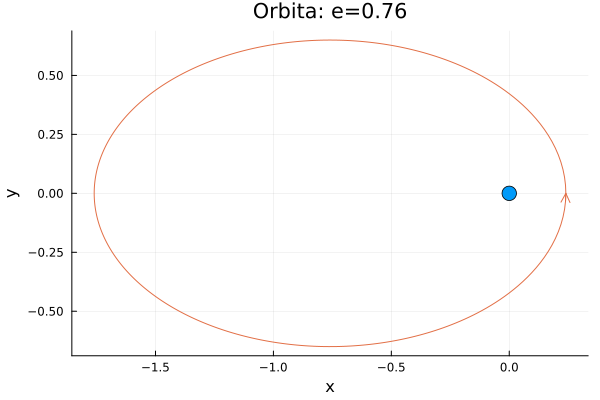

In [10]:
n=500
sol=RK5(prob_test,n)

tt = sol.t
xx = [u[1] for u in sol.u]
yy = [u[2] for u in sol.u]

plot([0.],[0.], marker=8, title="Orbita: e=$e", label="",  aspect_ratio=1)
plot!(xx,yy, arrow=true, xlabel="x", ylabel="y", label="")

**Se sabe que la solución exacta es periódica, con periodo $T=2 \pi$, de modo que el segundo cuerpo tiene las mismas posiciones y velocidades en $t=0$ y $t=T$. Por tanto, el error en el tiempo final $t_n=T$ se puede calcular de forma exacta.** 

\begin{align*}
\text{error}=\|u_{0}-u_{n}\|
\end{align*}

**Determinar el error en el tiempo final $t_n=T$ para diferentes aproximaciones obtenidas con el método RK5:  concretamente con las aproximaciones obtenidas aplicando n =[500, 1000, 1500, 3000, 6000] pasos.**  

In [11]:
steps= [500, 1000, 1500, 3000, 6000]

for n in steps
   sol=RK5(prob_test,n)
   error=norm(sol.u[1]-sol.u[end])
   println("pasos=",n, ", error=", Float32(error))
    
end

pasos=500, error=1.7303997e-5
pasos=1000, error=4.6328705e-7
pasos=1500, error=5.456921e-8
pasos=3000, error=1.4610486e-9
pasos=6000, error=3.9698397e-11


>**Comprobación**
>
> Se espera que al diminuir la longitud de paso el error vaya disminuyendo


**Para verificar que la implementación del método IRK5 es totalmente correcta, debe verificarse que el error obtenido
es propocional a $h^5$. Comprobarlo concretamente para las aproximaciones obtenidas aplicando n =[500, 1000, 1500, 3000, 6000] pasos.**

In [12]:
steps= [500, 1000, 1500, 3000, 6000]

t0,tf=prob_test.tspan
for n in steps
   sol=RK5(prob_test,n)
   h=(tf-t0)/n
   error=norm(sol.u[1]-sol.u[end])
   println("pasos=",n,  ", error/h^5=", Float32(error/h^5))
    
end

pasos=500, error/h^5=55220.09
pasos=1000, error/h^5=47309.77
pasos=1500, error/h^5=42316.0
pasos=3000, error/h^5=36255.31
pasos=6000, error/h^5=31523.17


>**Comprobación**
>
> Se observa que los errores a groso modo son proporcionales a $h^5$, es decir, 
$error=C \ h^5$ donde $3.e4 \le C \leq 5.5e4$


#### Estudio de la eficiencia de la implementación


Para evaluar la eficiencia de la implementación, emplearemos la **macro @time** que nos devuelve tanto el tiempo de ejecución (en segundos) como la memoria reservada empleada por una función. Debemos comprobar que la memoria reservada por la implementación del método RK5 sea constante e independiente de los pasos de integración.

Para ello ejecutaremos dos integraciones para $t \in [0,2\pi]$ que unicamente devuelve el estado inicial $u_0$ y la aproximación del estado $u$ en el tiempo final $t=2\pi$ verificando que en ambas el número de reservas de memoria es el mismo:

- Integración de $5000000$ pasos e indicando save_everystep=false. 
- Integración de $10000000$ pasos e indicando save_everystep=false.

In [13]:
n=1
m=5000000

sol=RK5(prob_test,n,m=m,save_everystep=false)
error=norm(sol.u[1]-sol.u[end])
println("num. pasos=",m,", num. resultados=",length(sol.t), ", error=",Float32(error))

@time RK5(prob_test,n,m=m,save_everystep=false);

num. pasos=5000000, num. resultados=2, error=8.251801e-11
  0.370481 seconds (20 allocations: 1.984 KiB)


In [14]:
n=1
m=10000000

sol=RK5(prob_test,n,m=m,save_everystep=false)
error=norm(sol.u[1]-sol.u[end])
println("num. pasos=",m,", num. resultados=",length(sol.t), ", error=",Float32(error))

@time RK5(prob_test,n,m=m,save_everystep=false);

num. pasos=10000000, num. resultados=2, error=3.617624e-11
  0.778345 seconds (20 allocations: 1.984 KiB)


>**Resultado esperado**
>
> La memoria reservada debe ser la misma en ambas ejecuciones: (20 allocations). En cambio, el tiempo de ejecución será aproximadamente proporcional al número de pasos dados.

### Implementación del método DOPRI5


### Ejercicio 2.2

En este apartado, implementaremos el método DOPRI5 en Julia.

Los argumentos de entrada son los siguientes:  $u_0, t_0, T, f, p, tol, h_0, \mathrm{maxtrials}$ y $\text{save_everystep}$.
El significado de los cinco primeros argumentos de entrada es el mismo que en RK4. Como argumentos de entrada adicionales, por un lado tenemos el entero positivo $\mathrm{maxtrials}$, que es el número máximo de longitud de pasos distintas que se intentarán en el cómputo de un paso de integración, y por otro lado, tenemos los números reales positivos tol y $h_0$:
tol es el parámetro de control de error descrito en el algoritmo, y $h_0$ es la longitud de paso inicial. El resultado de la función DOPRI5 será, como en RK4,  un objeto SolucionProblemaEDOs que contiene en el campo t los valores de los tiempos $t_0,t_1,t_2,\ldots$ de la discretización temporal no uniforme generada internamente por el algoritmo, en el campo u los vectores $u_j \approx u(t_j)$ ($j=0,1,2,\ldots$). Indicando en el argumento $\text{save_everystep}=false$ la función devolverá unicamente el valor inicial y final de la integración.


In [15]:
"""
Metodo de Runge-Kutta de orden 5 de Dormand y Prince (1981). 
Implementación con paso variable.
"""
function  DOPRI5(problema::ProblemaEDOs{ttype,utype,ptype,ftype},tol,h0;maxtrials=5,save_everystep=true) where {ttype <: AbstractFloat, utype <: AbstractArray, ptype <: AbstractArray, ftype}
 
      u0=problema.u0
      t0,T=problema.tspan
      p=problema.p
      f=problema.f
      #  
      (a,b,c,d) = DOPRI5Coefs() 
      #
      tiempos = ttype[]
      ues = utype[]

      F = Array{utype}(undef, 7)
      for i in 1:7 
        F[i]=zero(u0) 
      end  

      uj_= similar(u0) 
      uj1= similar(u0)
      Eh=zero(eltype(u0))    # para poder acceder fuera del while donde está definida
      #
      tj = t0
      uj=copy(u0)
      push!(tiempos,t0)
      push!(ues,copy(u0))  
      hj = h0
      final=false
        
      while (!final)
        
          accept=false
          i=0
          while !accept && i<maxtrials
            i+=1
            Eh = DOPRI5Step!(uj1,uj,tj,hj,f,p,uj_,F,
                             a,b,c,d)   
            if (Eh >= 2*tol) 
              hj = min(hj*(tol/Eh)^0.2,T-tj)  
            else
               accept=true
            end
          end
        
          if !accept && i==maxtrials
             println("Error en el paso tj=", tj, ", es necesario aumentar maxtrials=", maxtrials)
             return SolucionProblemaEDOs(tiempos, ues, array_vacio, problema)
          end

          tj += hj
          @. uj = uj1
          
          if save_everystep==true
             push!(tiempos,tj)
             push!(ues,copy(uj))
          end
            
          if tj==T
            final=true
          else
             hj = min(hj*(tol/Eh)^0.2, T-tj) 
          end

       end
    
       if save_everystep==false
          push!(tiempos,tj)
          push!(ues,copy(uj))
       end


       return SolucionProblemaEDOs(tiempos, ues, problema)
        
  end


    
function DOPRI5Step!(uj1,uj,tj,h,f,p,uj_,F,a,b,c,d)   

    f(F[1],tj, uj, p)  
    tj_=tj+c[2]*h
    @. uj_=uj+a[2,1]*h*F[1]
    f(F[2],tj_, uj_, p)
    tj_=tj+c[3]*h
    @. uj_=uj+a[3,1]*h*F[1]+a[3,2]*h*F[2]
    f(F[3],tj_, uj_, p)
    tj_=tj+c[4]*h
    @. uj_=uj+a[4,1]*h*F[1]+a[4,2]*h*F[2]+a[4,3]*h*F[3]
    f(F[4],tj_, uj_, p)
    tj_=tj+c[5]*h
    @. uj_=uj+a[5,1]*h*F[1]+a[5,2]*h*F[2]+a[5,3]*h*F[3]+a[5,4]*h*F[4]
    f(F[5],tj_, uj_, p)
    tj_=tj+c[6]*h
    @. uj_=uj+a[6,1]*h*F[1]+a[6,2]*h*F[2]+a[6,3]*h*F[3]+a[6,4]*h*F[4]+a[6,5]*h*F[5]
    f(F[6],tj_, uj_, p)
    @. uj1 = uj+h*(b[1]*F[1]+b[2]*F[2]+b[3]*F[3]+b[4]*F[4]+b[5]*F[5]+b[6]*F[6])
    f(F[7],tj+h,uj1,p)  
    
    @. uj_= h*(d[1]*F[1]+d[2]*F[2]+d[3]*F[3]+d[4]*F[4]+d[5]*F[5]+d[6]*F[6]+d[7]*F[7])
    Eh = norm(uj_)

    
    return  Eh

end       

DOPRI5Step! (generic function with 1 method)

#### Comprobaciones de la implementación DOPRI5

 - **Resolver numéricamente (con el método DOPRI5) el modelo de dos cuerpos en el plano aplicando $tol=1e-4, h_0=0.1 $ y mostrar dos gráficos:**
 

   1) La órbita de la evolución de satélite pero detallando la discretización empleada por el método DOPRI5.
   
   2) Mostrar un gráfico con las longitudes de paso empleadas  durante la integración.
  
Se observará que el método ha empleado una discretización más fina cerca del **perigeo** (zona de la órbita más cercana al primer cuerpo y donde la velocidad es mayor), que la empleada cerca del **apogeo** (zona de la órbita
más alejada del primer cuerpo)

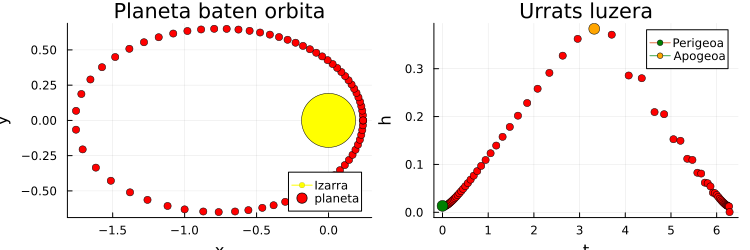

In [34]:
h0=0.1
tol=1.e-4
sol=DOPRI5(prob_test,tol,h0)

tt = sol.t
xx = [u[1] for u in sol.u]
yy = [u[2] for u in sol.u]

perigeo=1
apogeo=Int(argmax(map(x -> sqrt(x[1]*x[1]+x[2]*x[2]), sol.u)))

#title="Orbita: e=$e"
pl1=plot([0.],[0.], marker=30, color="yellow", title="Planeta baten orbita", label="Izarra"
         ,legend=:bottomright)
pl1=plot!(xx,yy, seriestype=:scatter, mc=:red, 
          xlabel="x", ylabel="y", label="planeta")
#pl1=plot!([xx[perigeo]],[yy[perigeo]], marker=6, mc=:green,label="")
#pl1=plot!([xx[apogeo]],[yy[apogeo]], marker=6, mc=:orange,label="")

pl2=plot(tt[1:end-1],tt[2:end]-tt[1:end-1], seriestype=:scatter, 
         title="Urrats luzera", label="", xlabel="t", ylabel="h", 
         mc=:red)

pl2=plot!([tt[perigeo]], [tt[perigeo+1]-tt[perigeo]],marker=6, mc=:green,label="Perigeoa")
pl2=plot!([tt[apogeo]], [tt[apogeo+1]-tt[apogeo]],marker=6, mc=:orange,label="Apogeoa")

plot(pl1, pl2,  layout=(1,2), size=(750,250) )


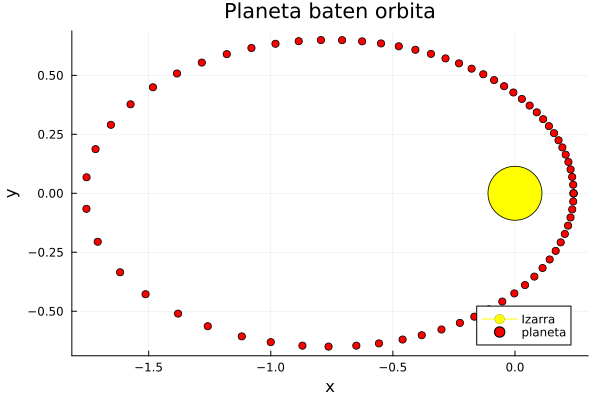

In [35]:
plot(pl1)

In [36]:
savefig("./sateliteae076")

"/home/mikel/Mahaigaina/Work-2021-2022/PIC/PIC-2022-2023/Atxiki Plazak/Aurkezpena/Irudi laguntzailea/Julia/sateliteae076.png"

- **Se sabe que la solución exacta es periódica, con periodo $T=2 \pi$, de modo que el segundo cuerpo tiene las mismas posiciones y velocidades en $t=0$ y $t=T$. Por tanto, el error en el tiempo final $t_n=T$ se puede calcular de forma exacta.** 

\begin{align*}
\text{error}=\|u_{0}-u_{n}\|
\end{align*}

**Determinar el error en el tiempo final $t_n=T$ para diferentes aproximaciones obtenidas con el método DOPRI5:  concretamente con las aproximaciones obtenidas aplicando las tolerancias tols =[1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10].** 

In [37]:
tols= [1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
h0=0.1

for tol in tols
    
   sol=DOPRI5(prob_test,tol,h0)
   error=norm(sol.u[1]-sol.u[end])
   println("pasos=",length(sol.t)-1, ", error=", Float32(error))
    
end

pasos=219, error=8.192064e-8
pasos=390, error=3.2361993e-9
pasos=693, error=1.2818764e-10
pasos=1233, error=4.7899033e-12
pasos=2192, error=1.4958173e-12


>**Comprobación**
> 
> Comparando estos resultados con los errores obtenidos en el apartado anterior con el método RK5, se comprueba que aplicando el mismo número de pasos en ambos métodos, el error obtenido con el método DOPRI5 es significativamente inferior.
> Concretamente se espera obtener los siguientes resultados:
>- pasos=219, error=8.192e-8
>- pasos=390, error=3.235e-9
>- pasos=693, error=1.285e-10
>- pasos=1233, error=3.522e-12
>- pasos=2192, error=1.391e-12

#### Estudio de la eficiencia de la implementación

**Para evaluar la eficiencia de la implementación, emplearemos la macro @time que nos devuelve tanto el tiempo de ejecución (en segundos) como la memoria reservada empleada por una función. Mediremos el tiempo de ejecución y memoria reservada de dos integraciones que unicamente devuelve el estado inicial $u_0$ y la aproximación del estado $u$ en el tiempo final $t=2\pi$**:

- Integración aplicando $tol=1.e-10$ y save_everystep=false
- Integración aplicando $tol=1.e-14$ y save_everystep=false

In [38]:
tol=1.e-10
sol=DOPRI5(prob_test,tol,h0)
sol_comp=DOPRI5(prob_test,tol,h0,save_everystep=false)    # compilación
@time DOPRI5(prob_test,tol,h0,save_everystep=false)
println("pasos=", length(sol.t)-1)

  0.000352 seconds (22 allocations: 2.250 KiB)
pasos=2192


In [39]:
tol=1.e-14
sol=DOPRI5(prob_test,tol,h0)
sol_comp=DOPRI5(prob_test,tol,h0,save_everystep=false)    # compilación
@time DOPRI5(prob_test,tol,h0,save_everystep=false)
println("pasos=", length(sol.t)-1)

  0.003398 seconds (22 allocations: 2.250 KiB)
pasos=21916


>**Resultado esperado**
>
> La memoria reservada debe ser la misma en ambas ejecuciones: (23 allocations). En cambio, el tiempo de ejecución será aproximadamente proporcional al número de pasos dados.

<a href="#top">Volver al inicio</a>

# Comparativa de eficiencia (error en energía)


### Ejercicio 3


Utilizaréis ambos versiones del método de orden 5 de Dormand y Prince para simular la evolución de las coordenadas $(x(t),y(t),z(t))$ de posición (y la velocidad $(v_x(t),v_y(t),v_z(t))$) del problema del satélite llamado **prob_sat** cuya órbita es aproximadamente periódica. Midiendo el error en la energía y tiempo de ejecución, se trata de determinar cual de los dos métodos resulta más eficiente para la simulación de satélites de gran excentricidad.

### Evolución de la energía para el método RK5


- **Aplicar el método RK5 al problema prob_sat, para calcular aproximaciones de la solución $u(t)=(x(t),y(t),z(t),v_x(t),v_y(t), v_z(t))$ para los valores de $t$ siguientes
\begin{equation*}
t_0=0, \ t_1=t_0+mh, \ t_2 = t_1+2mh, \ \ldots, \ t_{n}=t_{n-1}+nmh=T,
\end{equation*}
 donde $h=T/(n*m)$ con $n=10000, m=20$.**

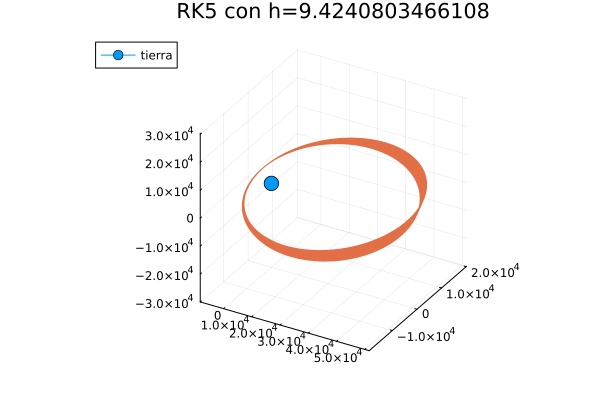

In [40]:
n = 10000
m= 20
 
sol = RK5(prob_sat,n,m=m)

t0=prob_sat.tspan[1]
tf=prob_sat.tspan[2]
dt=(tf-t0)/(n*m)
pasos_RK5=(tf-t0)/dt

tt = sol.t
xx = [u[1] for u in sol.u]
yy = [u[2] for u in sol.u]
zz = [u[3] for u in sol.u]

plot([0.],[0.],[0.],marker=8,label="tierra",
      title= "RK5 con h=$(dt)")
plot!(xx,yy,zz, aspect_ratio=1., zlimit=(-3.0e4,3.04e4),  label="")

- **Calcular los valores de la energía del sistema y representar dichos valores de la energía con respecto al tiempo.**

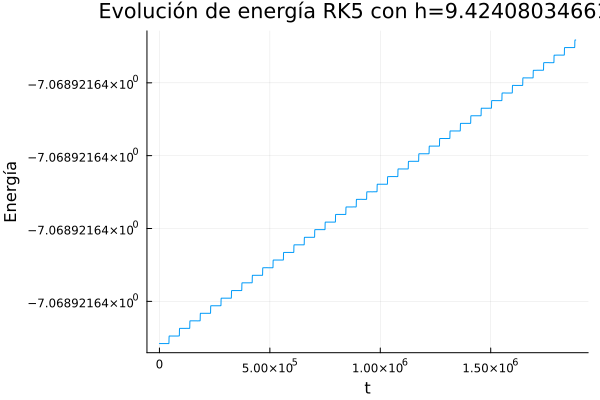

GKS: Possible loss of precision in routine SET_WINDOW


In [41]:
EE = zeros(n+1)
for i in 1:n+1
    EE[i] = Efun(sol.u[i],p_sat)
end

pl1=plot(sol.t,EE,
         xlabel="t",ylabel="Energía",label="", 
         title="Evolución de energía RK5 con h=$dt")

- **Calculo de _errores relativos en energía_**

Observese que la energía no se mantiene constante, sino que varía a lo largo del tiempo. Si para cada $k=1,2,\ldots,n$, la aproximación $u_k$ fuese igual a la solución exacta
$$u(t_k)=(x(t_k), y(t_k), z(t_k), v_x(t_k), v_y(t_k),v_z(t_k)),$$ 

entonces $E(u_k,p)$ sería exactamente igual a $E(u_0,p)$. Dichas variaciones del valor de la energía permiten medir de una forma sencilla el nivel de precisión de la aplicación del método RK5. Para ello, calcularemos los _errores relativos en energía_: para cada $k$, el error relativo en energía en $t=t_k$ es 
$$\big|E(u_k,p)/E(u_0,p)-1 \big|.$$ 
En lo que sigue, omitiremos el calificativo relativo y nos referiremos a él simplemente como _error en energía_.

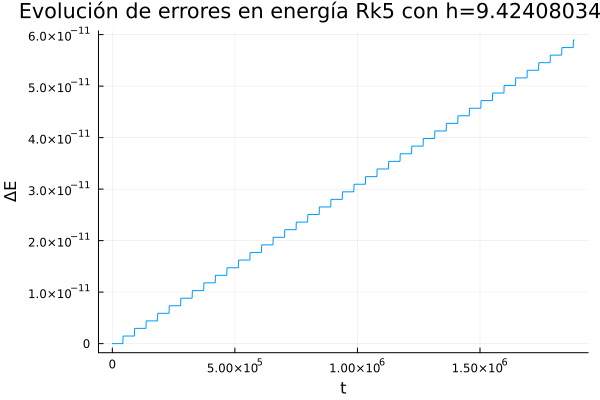

In [42]:
err = abs.(EE/EE[1].-1)
err_RK5=err[end]   # error relativo en energía al final de la integración

plot(sol.t,err,  
     xlabel="t",ylabel=ylabel="ΔE",label="", 
     title="Evolución de errores en energía Rk5 con h=$dt")

- **Cálculo del tiempo de ejecución**

En este caso, para medir la eficiencia de cada método emplearemos el macro **@elapsed** que devuelve el tiempo de computación (en segundos) de la ejecución de una función.
Para medir el tiempo de ejecución de una simulación de la manera más objetiva posible, consideraremos la media de los tiempos de CPU (elapsed time) en un número determinado de ejecuciones que fijaremos en el **parametro nruns** y aplicaremos **save_everystep=false**.

In [43]:
nruns=10

sol_comp=RK5(prob_sat,n,m=m,save_everystep=false)         # compilación
cpu_RK5=0.
for i in 1:nruns
    cpu_RK5+=@elapsed RK5(prob_sat,n,m=m,save_everystep=false) 
end
cpu_RK5=cpu_RK5/nruns

println("Longitud paso=",Float32(dt),",Numero de pasos: ",pasos_RK5, ", Tiempo CPU=", cpu_RK5, " s",", error en energia al final=", Float32(err_RK5))

Longitud paso=9.42408,Numero de pasos: 200000.0, Tiempo CPU=0.0258955567 s, error en energia al final=5.895162e-11


### Evolución de la energía para el método DOPRI5

**Repetir los cálculos del apartado anterior, pero aplicando el método DOPRI5 con tolerancia $\mathrm{tol}=10^{-6}$ y $h_0=0.1$.**

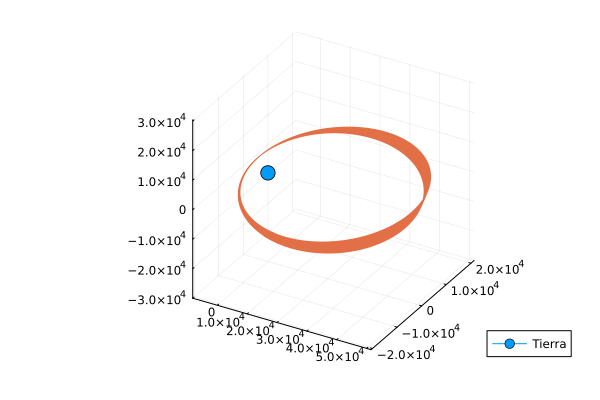

In [44]:
tol = 1.e-6
h0 = 0.1

sol = DOPRI5(prob_sat,tol,h0)    
pasos_DOPRI5=length(sol.u)-1

tt = sol.t
xx = [u[1] for u in sol.u]
yy = [u[2] for u in sol.u]
zz = [u[3] for u in sol.u]

plot([0.],[0.],[0.],marker=8,label="Tierra")
plot!(xx,yy,zz, aspect_ratio=1., zlimit=(-3.0e4,3.04e4),  label="")

- **Calculo de _errores relativos en energía_**

error en energia al final=3.354761e-12


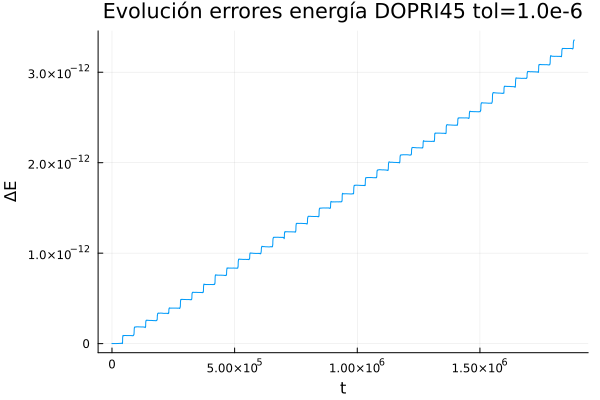

In [45]:
n=length(sol.t)
EE = zeros(n)

for i in 1:n
    EE[i] = Efun(sol.u[i],p_sat)
end

err = abs.(EE/EE[1].-1)
err_DOPRI5=err[end] # error relativo en energía al final de la integración
println("error en energia al final=", Float32(err_DOPRI5))

plot(sol.t,err, 
     xlabel="t",ylabel=ylabel="ΔE",label="", 
     title="Evolución errores energía DOPRI45 tol=$tol")

- **Cálculo del tiempo de ejecución**

In [46]:
sol_comp=DOPRI5(prob_sat,tol,h0,save_everystep=false)    # compilación
cpu_DOPRI5=0.
for i in 1:nruns
    cpu_DOPRI5+=@elapsed DOPRI5(prob_sat,tol,h0,save_everystep=false)
end
cpu_DOPRI5=cpu_DOPRI5/nruns

0.0154745069

### Conclusiones sobre la comparativa de eficiencia entre RK5 y DOPRI5

In [47]:
println("Numero de pasos: ",pasos_RK5, ", Tiempo CPU=", cpu_RK5, " s",", error en energia al final=", Float32(err_RK5))

Numero de pasos: 200000.0, Tiempo CPU=0.0258955567 s, error en energia al final=5.895162e-11


In [48]:
println("Numero de pasos: ",pasos_DOPRI5, ", Tiempo CPU=", cpu_DOPRI5, " s",", error en energia al final=", Float32(err_DOPRI5))

Numero de pasos: 69307, Tiempo CPU=0.0154745069 s, error en energia al final=3.354761e-12


> **¿Cuál de los dos métodos ha resultado más eficiente?**
>
> Con la implementación de paso variable (DOPRI5), se ha obtenido una mayor precisión con un número de pasos inferior y tiempo de ejecución similar, de modo que ha resultado más eficiente. Se observa que el cálculo de una paso del método de DOPRI5 es más costos que un paso de RK5.

<a href="#top">Volver al inicio</a>

# Comparativa de eficiencia (error en posiciones)


### Ejercicio 4

Utilizaréis ambos versiones del método de orden 5 de Dormand y Prince para simular la evolución de las coordenadas $(x(t),y(t),z(t))$ de posición (y la velocidad $(v_x(t),v_y(t),v_z(t))$) del problema del satélite llamado **prob_sat_simple** cuya órbita es periódica. Midiendo el error de forma exacta ($error=\|u_0-u_n\|$) y tiempo de ejecución, se trata de determinar cual de los dos métodos resulta más eficiente para la simulación de satélites de gran excentricidad.
 

###  Método RK5

- **Aplicar el método RK5 al problema prob_sat_simple, para calcular aproximaciones de la solución $u(t)=(x(t),y(t),z(t),v_x(t),v_y(t), v_z(t))$ para los valores de $t$ siguientes
\begin{equation*}
t_0=0, \ t_1=t_0+mh, \ t_2 = t_1+mh, \ \ldots, \ t_{n}=t_{n-1}+mh=T,
\end{equation*}
 donde $h=T/(n*m)$ con $n=10000, m=1$.** 

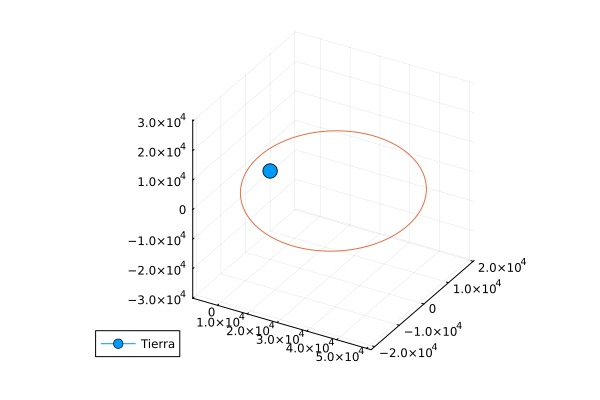

In [49]:
n = 10000
m= 1
sol = RK5(prob_sat_simple,n,m=m)

dt=(T-t0)/(n*m)
pasos_RK5_2=(T-t0)/dt

tt = sol.t
xx = [u[1] for u in sol.u]
yy = [u[2] for u in sol.u]
zz = [u[3] for u in sol.u]


plot([0.],[0.],[0.],marker=8,label="Tierra")
plot!(xx,yy,zz, aspect_ratio=1., zlimit=(-3.0e4,3.04e4),  label="") 

- **Se sabe que la solución exacta es periódica, con periodo $T$, de modo que tiene las mismas posiciones y velocidades en $t=0$ y $t=T$. Por tanto, el error en el tiempo final $t_n=T$ se puede calcular de forma exacta. .**

In [50]:
errfinalx = xx[end]-xx[1]
errfinaly = yy[end]-yy[1]
errfinalz = zz[end]-zz[1]
err_RK5_2 = sqrt(errfinalx^2 + errfinaly^2 + errfinalz^2)

5.3245953112600645e-9

- **Cálculamos los tiempos de ejecución**

In [51]:
nruns=10

sol_comp=RK5(prob_sat_simple,n,m=m,save_everystep=false)         # compilación
cpu_RK5_2=0.
for i in 1:nruns
    cpu_RK5_2+=@elapsed RK5(prob_sat_simple,n,m=m,save_everystep=false) 
end
cpu_RK5_2=cpu_RK5_2/nruns

println("Numero de pasos: ",pasos_RK5_2, ", Tiempo CPU=", cpu_RK5_2, " s",", error en posiciones al final=", Float32(err_RK5_2))

Numero de pasos: 10000.0, Tiempo CPU=0.0025543832 s, error en posiciones al final=5.3245954e-9


###  Método DOPRI5

**Repetir los cálculos del apartado anterior pero aplicando el método DOPRI5 con tolerancia $\mathrm{tol}=10^{-6}$ y $h_0=0.1$.**

In [52]:
tol = 1.e-6
h0 = 0.1

sol = DOPRI5(prob_sat_simple,tol,h0)
pasos_DOPRI5_2=length(sol.u)-1

tt = sol.t
xx = [u[1] for u in sol.u]
yy = [u[2] for u in sol.u]
zz = [u[3] for u in sol.u]

errfinalx = xx[end]-xx[1]
errfinaly = yy[end]-yy[1]
errfinalz = zz[end]-zz[1]
err_DOPRI5_2 = sqrt(errfinalx^2 + errfinaly^2 + errfinalz^2)


3.989463961233742e-9

- **Cálculamos los tiempos de ejecución**

In [53]:
sol_comp=DOPRI5(prob_sat_simple,tol,h0,save_everystep=false)    # compilación
cpu_DOPRI5_2=0.
for i in 1:nruns
    cpu_DOPRI5_2+=@elapsed DOPRI5(prob_sat_simple,tol,h0,save_everystep=false)
end
cpu_DOPRI5_2=cpu_DOPRI5_2/nruns

println("Numero de pasos: ",pasos_DOPRI5_2, ", Tiempo CPU=", cpu_DOPRI5_2, " s",", error en posicones al final=", Float32(err_DOPRI5_2))

Numero de pasos: 1734, Tiempo CPU=0.0003899112 s, error en posicones al final=3.989464e-9


### Conclusiones sobre la comparativa de eficiencia entre RK5 y DOPRI5

In [54]:
println("Numero de pasos: ",pasos_RK5_2, ", Tiempo CPU=", cpu_RK5_2, " s",", error en posiciones al final=", Float32(err_RK5_2))

Numero de pasos: 10000.0, Tiempo CPU=0.0025543832 s, error en posiciones al final=5.3245954e-9


In [55]:
println("Numero de pasos: ",pasos_DOPRI5_2, ", Tiempo CPU=", cpu_DOPRI5_2, " s",", error en posicones al final=", Float32(err_DOPRI5_2))

Numero de pasos: 1734, Tiempo CPU=0.0003899112 s, error en posicones al final=3.989464e-9


> **¿Cuál de los dos métodos ha resultado más eficiente?**
>
>> Con la implementación de paso variable (DOPRI5), se ha obtenido un precisión similar con un número de pasos y tiempo de ejecución menor, de modo que ha resultado más eficiente

<a href="#top">Volver al inicio</a>